In this experiment we try the gaussin noise with a net including two dropout layers, to check the behaviour in case of gaussian noise. 

### **LIBRERIE**

In [ ]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.xception import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.optimizers import adam_v2

import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import tensorflow.keras as tfk
import tensorflow.keras.layers as tfkl
import random
import os
import tensorflow as tf
from PIL import Image
import logging
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
print(tf.__version__)

2.6.0


### Set seed for reproducibility

In [ ]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

#**DATASET**

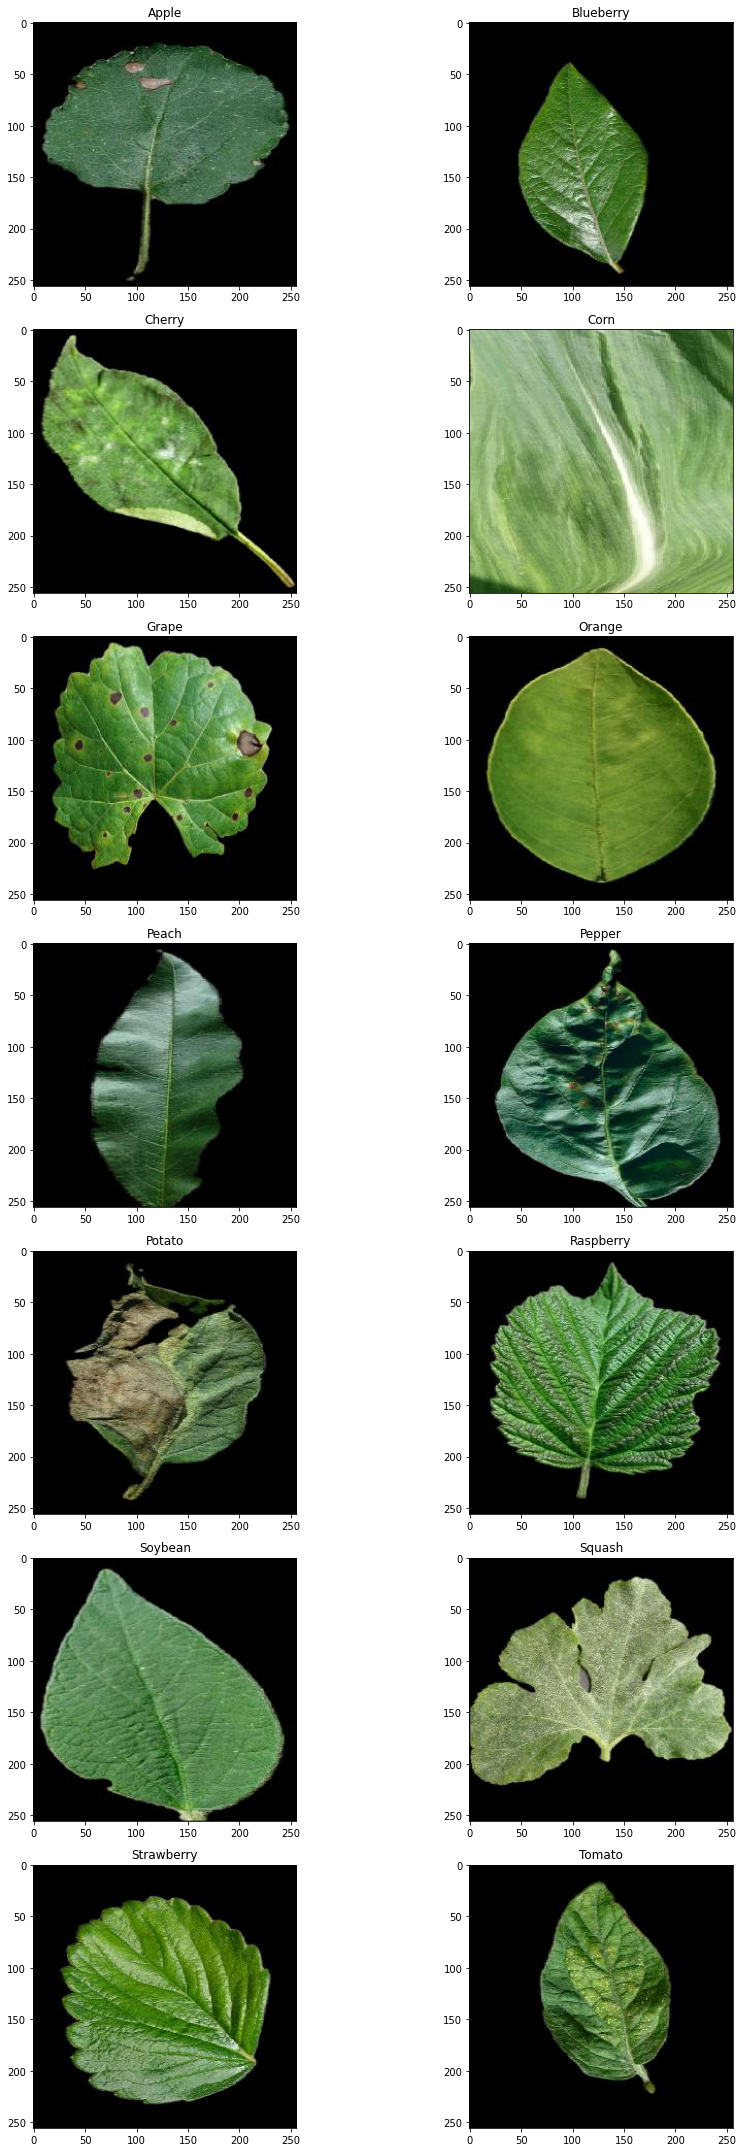

In [ ]:
dataset_dir = '../input/superduperbilanciato/leaves_overUnder_sampled_more' 

training_dir = os.path.join(dataset_dir, 'train')
validation_dir = os.path.join(dataset_dir, 'val')
test_dir = os.path.join(dataset_dir, 'test') 

# Plot example images from dataset
labels = ['Apple','Blueberry','Cherry','Corn','Grape','Orange','Peach','Pepper','Potato','Raspberry','Soybean','Squash','Strawberry','Tomato']

from tensorflow.keras.utils import to_categorical



num_row = len(labels)//2
num_col = len(labels)//num_row
fig, axes = plt.subplots(num_row, num_col, figsize=(2*num_row,15*num_col))
for i in range(len(labels)):
  if i < len(labels):
    class_imgs = next(os.walk('{}/train/{}/'.format(dataset_dir, labels[i])))[2]
    class_img = class_imgs[0]
    img = Image.open('{}/train/{}/{}'.format(dataset_dir, labels[i], class_img))
    ax = axes[i//num_col, i%num_col]
    ax.imshow(np.array(img))
    ax.set_title('{}'.format(labels[i]))
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Number of training images per category:')

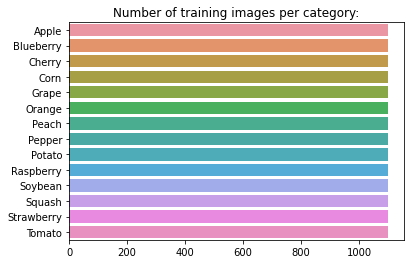

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
category_names = sorted(os.listdir(training_dir))
nb_categories = len(category_names)
img_pr_cat = []
for category in category_names:
    folder = training_dir + '/' + category
    img_pr_cat.append(len(os.listdir(folder)))
sns.barplot(y=category_names, x=img_pr_cat).set_title("Number of training images per category:")

###**DATA AUGMENTATION**

In [ ]:
# Create an instance of ImageDataGenerator with Data Augmentation
aug_train_data_gen = ImageDataGenerator(rotation_range=180,
                                        height_shift_range=150,
                                        width_shift_range=200,
                                        zoom_range=0.5,
                                        horizontal_flip=True,
                                        vertical_flip=False, 
                                        fill_mode='constant',
                                        cval=0,
                                        preprocessing_function = preprocess_input,
                                        # rescale=1/255. non worka con vgg16
                                        ) # rescale value is multiplied to the image
valid_data_gen = ImageDataGenerator(#rescale=1/255.,
                                    preprocessing_function = preprocess_input)
test_data_gen = ImageDataGenerator(#rescale=1/255.,
                                   preprocessing_function = preprocess_input)

# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
aug_train_gen = aug_train_data_gen.flow_from_directory(directory=training_dir,
                                                       target_size=(256,256),
                                                       color_mode='rgb',
                                                       classes=None, # can be set to labels
                                                       class_mode='categorical',
                                                       batch_size=32,
                                                       shuffle=True,
                                                       seed=seed)

valid_gen = valid_data_gen.flow_from_directory(directory=validation_dir,
                                               target_size=(256,256),
                                               color_mode='rgb',
                                               classes=None, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=32,
                                               shuffle=True,
                                               seed=seed)
test_gen = test_data_gen.flow_from_directory(directory=test_dir,
                                             target_size=(256,256),
                                             color_mode='rgb',
                                             classes=None, # can be set to labels
                                             class_mode='categorical',
                                             batch_size=32,
                                             shuffle=False,
                                             seed=seed)

Found 15400 images belonging to 14 classes.
Found 7000 images belonging to 14 classes.
Found 1785 images belonging to 14 classes.


#**CALLBACKS**

In [ ]:

class RandomSttdev(tf.keras.callbacks.Callback):
    
    def on_epoch_begin(self, epoch, logs=None):
        self.model.layers[2].stddev = random.uniform(0, 0.5)
        print('updating sttdev in training')
        print(self.model.layers[2].stddev)
        
    
    

In [ ]:
# Utility function to create folders and callbacks for training
from datetime import datetime

def create_folders_and_callbacks(model_name):

  exps_dir = os.path.join('transfer_learning_experiments')
  if not os.path.exists(exps_dir):
      os.makedirs(exps_dir)

  now = datetime.now().strftime('%b%d_%H-%M-%S')

  exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
  if not os.path.exists(exp_dir):
      os.makedirs(exp_dir)

  callbacks = []

  # Model checkpoint
  # ----------------
  ckpt_dir = os.path.join(exp_dir, 'ckpts')
  if not os.path.exists(ckpt_dir):
      os.makedirs(ckpt_dir)

  ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp.ckpt'), 
                                                     save_weights_only=False, # True to save only weights
                                                     save_best_only=False) # True to save only the best epoch 
  callbacks.append(ckpt_callback)

  # Visualize Learning on Tensorboard
  # ---------------------------------
  tb_dir = os.path.join(exp_dir, 'tb_logs')
  if not os.path.exists(tb_dir):
      os.makedirs(tb_dir)

  # By default shows losses and metrics for both training and validation
  tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir, 
                                               profile_batch=0,
                                               histogram_freq=1)  # if > 0 (epochs) shows weights histograms
  callbacks.append(tb_callback)

  # Early Stopping
  # --------------
  es_callback  = tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)
  callbacks.append(es_callback)

  return callbacks

# **Transfer learning**

In [ ]:
tl_callbacks = create_folders_and_callbacks(model_name = 'transfer_learning')
#rand_sttdev = RandomSttdev()

base_model = tfk.applications.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(299, 299, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top.

base_model.trainable = False
inputs = tfk.Input(shape=(256, 256, 3))
x = tf.keras.layers.Resizing(
    299, 299, interpolation='bilinear', crop_to_aspect_ratio=True,) (inputs)
#x = tf.keras.layers.BatchNormalization(axis=1, scale=False)(x)
x = base_model(x, training=False)
x = tfk.layers.Flatten(name='Flattening')(x)
x = tfkl.Dropout(0.3, seed=seed)(x)
x = tfkl.Dense(
    256, 
    activation='relu',
    kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)
x = tf.keras.layers.GaussianNoise(0.5)(x)
x = tfkl.Dropout(0.3, seed=seed)(x)
output_layer = tfkl.Dense(units=14, activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(seed), name='Output')(x)

tl_model = tfk.Model(inputs, output_layer)

tl_model.compile(optimizer=tfk.optimizers.Adam(),
              loss=tfk.losses.CategoricalCrossentropy(),
              metrics= 'accuracy')
tl_model.summary()

83697664/83683744 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
resizing (Resizing)          (None, 299, 299, 3)       0         
_________________________________________________________________
xception (Functional)        (None, 10, 10, 2048)      20861480  
_________________________________________________________________
Flattening (Flatten)         (None, 204800)            0         
_________________________________________________________________
dropout (Dropout)            (None, 204800)            0         
_________________________________________________________________
dense (Dense)                (None, 256)               52429056  
______________________________________________________________

In [ ]:
# Train the model

tl_history = tl_model.fit(x = aug_train_gen, epochs=200, callbacks=[tl_callbacks], validation_data=valid_gen)

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/200
482/482 [==============================] - 320s 643ms/step - loss: 2.9190 - accuracy: 0.2486 - val_loss: 1.2369 - val_accuracy: 0.6230


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/200
482/482 [==============================] - 285s 592ms/step - loss: 1.9346 - accuracy: 0.3638 - val_loss: 0.8963 - val_accuracy: 0.6994


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 3/200
482/482 [==============================] - 260s 539ms/step - loss: 1.7006 - accuracy: 0.4277 - val_loss: 0.7535 - val_accuracy: 0.7644


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 4/200
482/482 [==============================] - 255s 529ms/step - loss: 1.5513 - accuracy: 0.4799 - val_loss: 0.6195 - val_accuracy: 0.8230


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 5/200
482/482 [==============================] - 255s 530ms/step - loss: 1.4747 - accuracy: 0.5069 - val_loss: 0.5883 - val_accuracy: 0.7909


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 6/200
482/482 [==============================] - 254s 527ms/step - loss: 1.4056 - accuracy: 0.5336 - val_loss: 0.4713 - val_accuracy: 0.8497


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 7/200
482/482 [==============================] - 255s 529ms/step - loss: 1.3536 - accuracy: 0.5556 - val_loss: 0.3955 - val_accuracy: 0.8853


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 8/200
482/482 [==============================] - 264s 547ms/step - loss: 1.3058 - accuracy: 0.5719 - val_loss: 0.4238 - val_accuracy: 0.8793


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 9/200
482/482 [==============================] - 260s 539ms/step - loss: 1.2720 - accuracy: 0.5886 - val_loss: 0.4877 - val_accuracy: 0.8343


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 10/200
482/482 [==============================] - 255s 528ms/step - loss: 1.2364 - accuracy: 0.5973 - val_loss: 0.4001 - val_accuracy: 0.8700


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 11/200
482/482 [==============================] - 302s 627ms/step - loss: 1.2354 - accuracy: 0.5951 - val_loss: 0.3745 - val_accuracy: 0.8959


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 12/200
482/482 [==============================] - 267s 554ms/step - loss: 1.2034 - accuracy: 0.6125 - val_loss: 0.3896 - val_accuracy: 0.8977


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 13/200
482/482 [==============================] - 264s 547ms/step - loss: 1.1888 - accuracy: 0.6143 - val_loss: 0.3095 - val_accuracy: 0.9091


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 14/200
482/482 [==============================] - 272s 564ms/step - loss: 1.1781 - accuracy: 0.6205 - val_loss: 0.3039 - val_accuracy: 0.9133


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 15/200
482/482 [==============================] - 263s 546ms/step - loss: 1.1391 - accuracy: 0.6310 - val_loss: 0.2301 - val_accuracy: 0.9424


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 16/200
482/482 [==============================] - 283s 588ms/step - loss: 1.1455 - accuracy: 0.6328 - val_loss: 0.2890 - val_accuracy: 0.9264


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 17/200
482/482 [==============================] - 275s 571ms/step - loss: 1.1346 - accuracy: 0.6329 - val_loss: 0.2849 - val_accuracy: 0.9206


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 18/200
482/482 [==============================] - 274s 569ms/step - loss: 1.1372 - accuracy: 0.6362 - val_loss: 0.2979 - val_accuracy: 0.9091


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 19/200
482/482 [==============================] - 267s 554ms/step - loss: 1.1207 - accuracy: 0.6392 - val_loss: 0.2862 - val_accuracy: 0.9233


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 20/200
482/482 [==============================] - 268s 556ms/step - loss: 1.1044 - accuracy: 0.6469 - val_loss: 0.2163 - val_accuracy: 0.9457


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 21/200
482/482 [==============================] - 273s 565ms/step - loss: 1.1368 - accuracy: 0.6372 - val_loss: 0.2412 - val_accuracy: 0.9306


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 22/200
482/482 [==============================] - 272s 565ms/step - loss: 1.0950 - accuracy: 0.6510 - val_loss: 0.2169 - val_accuracy: 0.9357


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 23/200
482/482 [==============================] - 265s 549ms/step - loss: 1.1083 - accuracy: 0.6442 - val_loss: 0.2373 - val_accuracy: 0.9317


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 24/200
482/482 [==============================] - 256s 530ms/step - loss: 1.0891 - accuracy: 0.6515 - val_loss: 0.2264 - val_accuracy: 0.9420


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 25/200
482/482 [==============================] - 260s 540ms/step - loss: 1.0883 - accuracy: 0.6540 - val_loss: 0.2611 - val_accuracy: 0.9369


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 26/200
482/482 [==============================] - 263s 546ms/step - loss: 1.0763 - accuracy: 0.6539 - val_loss: 0.2175 - val_accuracy: 0.9384


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 27/200
482/482 [==============================] - 280s 582ms/step - loss: 1.0912 - accuracy: 0.6536 - val_loss: 0.2278 - val_accuracy: 0.9480


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 28/200
482/482 [==============================] - 258s 535ms/step - loss: 1.0920 - accuracy: 0.6502 - val_loss: 0.1922 - val_accuracy: 0.9516


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 29/200
482/482 [==============================] - 263s 545ms/step - loss: 1.0672 - accuracy: 0.6592 - val_loss: 0.2577 - val_accuracy: 0.9361


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 30/200
482/482 [==============================] - 267s 553ms/step - loss: 1.0781 - accuracy: 0.6556 - val_loss: 0.2698 - val_accuracy: 0.9259


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 31/200
482/482 [==============================] - 258s 536ms/step - loss: 1.0716 - accuracy: 0.6560 - val_loss: 0.2243 - val_accuracy: 0.9320


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 32/200
482/482 [==============================] - 260s 540ms/step - loss: 1.0697 - accuracy: 0.6606 - val_loss: 0.2144 - val_accuracy: 0.9391


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 33/200
482/482 [==============================] - 259s 536ms/step - loss: 1.0320 - accuracy: 0.6711 - val_loss: 0.2091 - val_accuracy: 0.9363


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 34/200
482/482 [==============================] - 262s 543ms/step - loss: 1.0504 - accuracy: 0.6659 - val_loss: 0.2044 - val_accuracy: 0.9476


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 35/200
482/482 [==============================] - 259s 538ms/step - loss: 1.0545 - accuracy: 0.6642 - val_loss: 0.2532 - val_accuracy: 0.9276


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 36/200
482/482 [==============================] - 275s 569ms/step - loss: 1.0323 - accuracy: 0.6733 - val_loss: 0.1941 - val_accuracy: 0.9531


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 37/200
482/482 [==============================] - 260s 539ms/step - loss: 1.0575 - accuracy: 0.6686 - val_loss: 0.1774 - val_accuracy: 0.9497


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 38/200
482/482 [==============================] - 260s 540ms/step - loss: 1.0493 - accuracy: 0.6658 - val_loss: 0.2044 - val_accuracy: 0.9446


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 39/200
482/482 [==============================] - 260s 539ms/step - loss: 1.0456 - accuracy: 0.6691 - val_loss: 0.2322 - val_accuracy: 0.9321


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 40/200
482/482 [==============================] - 260s 538ms/step - loss: 1.0364 - accuracy: 0.6717 - val_loss: 0.2130 - val_accuracy: 0.9331


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 41/200
482/482 [==============================] - 254s 528ms/step - loss: 1.0272 - accuracy: 0.6779 - val_loss: 0.2314 - val_accuracy: 0.9444


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 42/200
482/482 [==============================] - 265s 549ms/step - loss: 1.0299 - accuracy: 0.6749 - val_loss: 0.1987 - val_accuracy: 0.9470


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 43/200
482/482 [==============================] - 266s 552ms/step - loss: 1.0246 - accuracy: 0.6751 - val_loss: 0.2118 - val_accuracy: 0.9456


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 44/200
482/482 [==============================] - 269s 559ms/step - loss: 1.0214 - accuracy: 0.6730 - val_loss: 0.2277 - val_accuracy: 0.9406


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 45/200
482/482 [==============================] - 295s 612ms/step - loss: 1.0263 - accuracy: 0.6793 - val_loss: 0.2265 - val_accuracy: 0.9397


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 46/200
482/482 [==============================] - 274s 569ms/step - loss: 1.0261 - accuracy: 0.6766 - val_loss: 0.2015 - val_accuracy: 0.9446


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


# Plot the training

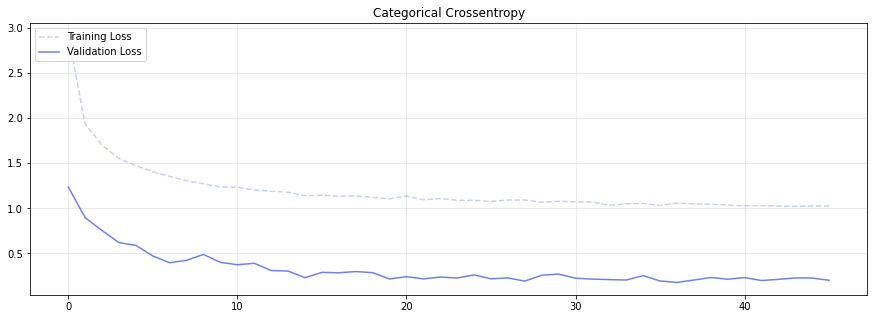

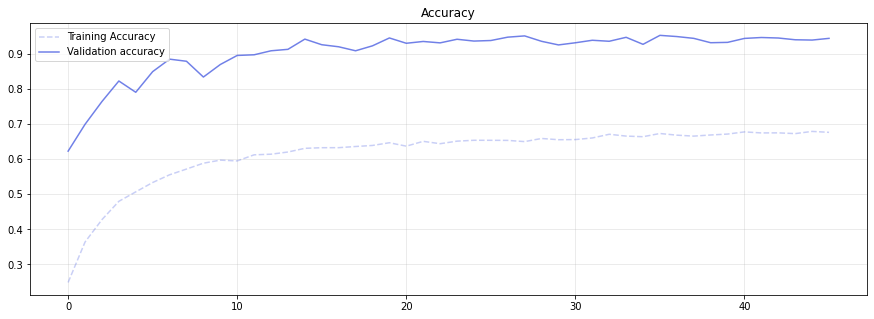

In [ ]:
plt.figure(figsize=(15,5))

plt.plot(tl_history.history['loss'],label = 'Training Loss', alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history.history['val_loss'], label='Validation Loss', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))

plt.plot(tl_history.history['accuracy'],label = 'Training Accuracy' , alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history.history['val_accuracy'], label='Validation accuracy', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

# Save the best model

In [ ]:
tl_model.save('DadoDato.h5')
#del tl_model  # To avoid filling the memory



>TEST



In [ ]:
# Trained with data augmentation
test_model = tl_model.evaluate(test_gen, return_dict=True)

print()
print("Test metrics without data augmentation")
print(test_model)

56/56 [==============================] - 18s 320ms/step - loss: 0.2871 - accuracy: 0.9232

Test metrics without data augmentation
{'loss': 0.2871460020542145, 'accuracy': 0.9232493042945862}


## **FINE TUNING**

In [ ]:
# Re-load the model after transfer learning
ft_model = tl_model#tfk.models.load_model('DadoDato.h5')
ft_model.summary()
# Set all VGG layers to True
ft_model.get_layer('xception').trainable = True
for i, layer in enumerate(ft_model.get_layer('xception').layers):
   print(i, layer.name, layer.trainable)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
resizing (Resizing)          (None, 299, 299, 3)       0         
_________________________________________________________________
xception (Functional)        (None, 10, 10, 2048)      20861480  
_________________________________________________________________
Flattening (Flatten)         (None, 204800)            0         
_________________________________________________________________
dropout (Dropout)            (None, 204800)            0         
_________________________________________________________________
dense (Dense)                (None, 256)               52429056  
_________________________________________________________________
gaussian_noise (GaussianNois (None, 256)               0     

In [ ]:
# Freeze first N layers
for i, layer in enumerate(ft_model.get_layer('xception').layers[:125]):
  layer.trainable=False
for i, layer in enumerate(ft_model.get_layer('xception').layers):
   print(i, layer.name, layer.trainable)
ft_model.summary()

0 input_1 False
1 block1_conv1 False
2 block1_conv1_bn False
3 block1_conv1_act False
4 block1_conv2 False
5 block1_conv2_bn False
6 block1_conv2_act False
7 block2_sepconv1 False
8 block2_sepconv1_bn False
9 block2_sepconv2_act False
10 block2_sepconv2 False
11 block2_sepconv2_bn False
12 conv2d False
13 block2_pool False
14 batch_normalization False
15 add False
16 block3_sepconv1_act False
17 block3_sepconv1 False
18 block3_sepconv1_bn False
19 block3_sepconv2_act False
20 block3_sepconv2 False
21 block3_sepconv2_bn False
22 conv2d_1 False
23 block3_pool False
24 batch_normalization_1 False
25 add_1 False
26 block4_sepconv1_act False
27 block4_sepconv1 False
28 block4_sepconv1_bn False
29 block4_sepconv2_act False
30 block4_sepconv2 False
31 block4_sepconv2_bn False
32 conv2d_2 False
33 block4_pool False
34 batch_normalization_2 False
35 add_2 False
36 block5_sepconv1_act False
37 block5_sepconv1 False
38 block5_sepconv1_bn False
39 block5_sepconv2_act False
40 block5_sepconv2 False

In [ ]:
# Compile the model
ft_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-4), metrics='accuracy')

# Fine-tune the model
ft_history = ft_model.fit(
    x = aug_train_gen ,
    epochs = 200,
    validation_data = valid_gen,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10,verbose= 2 , restore_best_weights=True)]
).history

Epoch 1/200
482/482 [==============================] - 305s 623ms/step - loss: 0.9729 - accuracy: 0.6905 - val_loss: 0.1745 - val_accuracy: 0.9399
Epoch 2/200
482/482 [==============================] - 311s 645ms/step - loss: 0.8550 - accuracy: 0.7223 - val_loss: 0.1440 - val_accuracy: 0.9597
Epoch 3/200
482/482 [==============================] - 267s 553ms/step - loss: 0.8030 - accuracy: 0.7417 - val_loss: 0.1337 - val_accuracy: 0.9619
Epoch 4/200
482/482 [==============================] - 268s 556ms/step - loss: 0.7453 - accuracy: 0.7604 - val_loss: 0.1024 - val_accuracy: 0.9684
Epoch 5/200
482/482 [==============================] - 270s 560ms/step - loss: 0.6876 - accuracy: 0.7814 - val_loss: 0.1058 - val_accuracy: 0.9683
Epoch 6/200
482/482 [==============================] - 270s 560ms/step - loss: 0.6492 - accuracy: 0.7963 - val_loss: 0.0628 - val_accuracy: 0.9816
Epoch 7/200
482/482 [==============================] - 270s 560ms/step - loss: 0.5855 - accuracy: 0.8177 - val_loss: 0

In [ ]:
#Save the best model
ft_model.save('GaussianDropOut.h5')
#del tl_model  # To avoid filling the memory



In [ ]:
# Trained with data augmentation
FT_test = ft_model.evaluate(test_gen, return_dict=True)

print()
print("Test metrics without data augmentation")
print(FT_test)

56/56 [==============================] - 9s 157ms/step - loss: 0.0301 - accuracy: 0.9910

Test metrics without data augmentation
{'loss': 0.030085040256381035, 'accuracy': 0.9910364151000977}


In [ ]:
print(f"val_acc:{max(ft_history['val_accuracy'])} val_loss: {min(ft_history['val_loss'])}")
print(f"train_acc:{max(ft_history['accuracy'])} train_loss: {min(ft_history['loss'])}")

val_acc:0.99314284324646 val_loss: 0.024632494896650314
train_acc:0.9003247022628784 train_loss: 0.31893840432167053
